In [2]:
#%pylab qt5
#%precision 5
#set_printoptions(precision=5)
%matplotlib inline
#matplotlib.rcParams['figure.figsize'] = (11, 7)
import networkx as nx
import numpy as np
import scipy
import matplotlib.cm as cm
import matplotlib.pyplot as plt

To see how the karate club graph looks like:

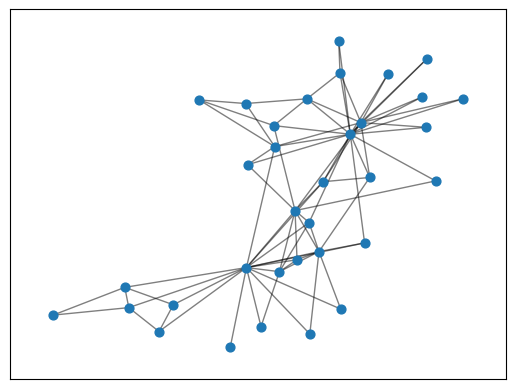

In [37]:
# load the karate club graph
G = nx.karate_club_graph()
# draw the graph
pos = nx.spring_layout(G)
# color the nodes according to their partition
#cmap = cm.get_cmap('viridis', max(partition.values()) + 1)
#nx.draw_networkx_nodes(G, pos, partition.keys(), node_size=40, cmap=cmap, node_color=list(partition.values()))
nx.draw_networkx_nodes(G, pos, node_size=40)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

Defining some functions: (don't need init at the moment)

In [6]:
def phi(dist):
    """
    threshold function
    """
    if dist<1:
        res=1-dist
    else:
        res=0
    return res

In [3]:
def init():
    """
    Chooses a graph and assigns a number between -1 and 1 to each vertex
    """
    G = nx.karate_club_graph()
    for i in range(G.number_of_nodes()):
        G.nodes[i]['startval']=2*np.random.random()-1
    return G

In [7]:
def abl(t,arr):
    """
    The derivative function for solving the dynamics
    """
    inc=nx.incidence_matrix(G,oriented=True).toarray()
    v=[]
    for k in nx.edges(G):
        v=np.append(v,[phi(abs(arr[k[0]]-arr[k[1]]))])
    return -np.dot(np.matmul(np.matmul(inc,np.diag(v)),np.transpose(inc)),arr)

So now let us do one self-contained cell for solving the dynamics:

In [46]:
def sol(G):
    """
    solves the dynamics for a given graph and a random starting distribution
    """
    y=[] #start value
    for i in range(G.number_of_nodes()):
        y=np.append(y,3*np.random.random()-1.5) #ok, range 2 scheint zu niedrig zu sein, range 3 ist schon besser...
    return scipy.integrate.solve_ivp(abl,[0,100],y,t_eval=[100])

Now want to cluster the nodes by their final value. The following can be used to calculate clusters given a solution vector:

In [78]:
sollim=sol(G)
cluster=np.zeros(G.number_of_nodes())
for i in range(G.number_of_nodes()):
    if cluster[i]==0:
        cluster[i]=np.max(cluster)+1
        for k in range(i,G.number_of_nodes()):
            if abs(sollim.y[i][0]-sollim.y[k][0])<0.001:
                cluster[k]=cluster[i]

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/3994252088.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()


Now we would like to represent such a partition:

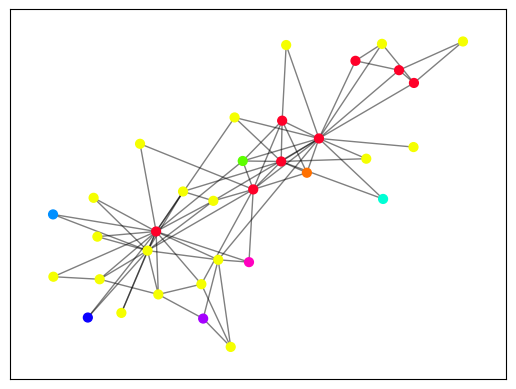

In [44]:
cmap = cm.get_cmap('gist_rainbow', int(np.max(cluster)+1))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=40, cmap=cmap, node_color=cluster)
nx.draw_networkx_edges(G, pos, alpha=0.5)
plt.show()

Next, we would like to have many runs and calculate an "average". There are two versions for this:
Lets first try to compare entire partitions - although I'm not sure if there will be a repetition at all, due to many outliers (no repetition for 11 samples - duration on my laptop about 2.2s per sample)
First combine solving with calculating cluster.

In [47]:
def part(G):
    """
    Calculates a partition of a given graph
    """
    y=[]
    for i in range(G.number_of_nodes()):
        y=np.append(y,3*np.random.random()-1.5)
    sollim=scipy.integrate.solve_ivp(abl,[0,100],y,t_eval=[100])
    cluster=np.zeros(G.number_of_nodes())
    for i in range(G.number_of_nodes()):
        if cluster[i]==0:
            cluster[i]=np.max(cluster)+1
            for k in range(i,G.number_of_nodes()):
                if abs(sollim.y[i][0]-sollim.y[k][0])<0.001:
                    cluster[k]=cluster[i]
    return cluster

In [80]:
G=nx.karate_club_graph()
res=np.array([[part(G),1]])
for i in range(10):
    p=part(G)
    for k in range(len(res[:,0])):
        b=0
        if (res[k,0]==p).all():
            res[k,1]=res[k,1]+1
            b=1
    if b==0:
        res=np.vstack([res,[p,1]])
    print(i)
print(np.max(res[:,1]))

/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/3994252088.py:5: FutureWarning: incidence_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  inc=nx.incidence_matrix(G,oriented=True).toarray()
/var/folders/mb/j4ltv8_d73q_cwpdwmzz5byw0000gn/T/ipykernel_995/1496640131.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  res=np.array([[part(G),1]])
/Users/arne/opt/anaconda3/lib/python3.9/site-packages/numpy/core/shape_base.py:121: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


0
1
2
3
4
5
6
7
8
9
[[array([1., 1., 1., 2., 3., 1., 1., 1., 1., 2., 1., 4., 1., 2., 2., 2., 1.,
         1., 1., 1., 2., 5., 2., 1., 1., 1., 6., 1., 1., 2., 1., 2., 1., 2.])
  1]
 [array([1., 1., 1., 1., 2., 1., 1., 1., 3., 4., 1., 1., 1., 1., 1., 3., 5.,
         1., 1., 6., 3., 1., 3., 3., 1., 1., 1., 1., 1., 1., 1., 1., 3., 1.])
  1]
 [array([1., 1., 2., 1., 3., 1., 1., 2., 2., 2., 1., 1., 1., 2., 1., 4., 1.,
         5., 6., 1., 1., 1., 7., 2., 2., 1., 2., 2., 1., 2., 2., 8., 8., 8.])
  1]
 [array([1., 1., 1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 3., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])
  1]
 [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 2., 3., 1., 1., 2., 1., 1., 1., 1., 1., 1.])
  1]
 [array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 3., 1., 4., 1.,
         1., 5., 1., 6., 1., 1., 1., 1., 1., 7., 1., 1., 7., 8., 1., 1., 1.])
  1]
 [array([1., 2., 2.,

In [84]:
np.max(res[:,1])

1

In [83]:
res[:,1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=object)